In [1]:
import tensorflow as tf
import numpy as np
import jax
import jax.numpy as jnp
import jax.experimental.optimizers as optimizers
from jax.experimental import stax
from jax.experimental.stax import (Conv, Dense, MaxPool, Relu, Flatten)
from jax import jit, grad, random,vmap,value_and_grad
import jax.nn as jnn
from jax.tree_util import tree_multimap
import math
from scipy.special import softmax
import matplotlib.pyplot as plt
import warnings
from functools import partial # for use with vmap


In [2]:
def data_parse(record):
    features = {
        'N': tf.io.FixedLenFeature([], tf.int64),
        'labels': tf.io.FixedLenFeature([16], tf.float32),
        'elements': tf.io.VarLenFeature(tf.int64),
        'coords': tf.io.VarLenFeature(tf.float32),
    }
    parsed_features = tf.io.parse_single_example(
        serialized=record, features=features)
    coords = tf.reshape(tf.sparse.to_dense(parsed_features['coords'], default_value=0),[-1,4])
    elements = tf.sparse.to_dense(parsed_features['elements'], default_value=0)
    return (elements, coords), parsed_features['labels']
data = tf.data.TFRecordDataset(
    'qm9.tfrecords', compression_type='GZIP').map(data_parse)

In [3]:
#{'C':6,'H':1,'O':8,'N':7,'F':9}

def make_graph(e,x):
    e = e.numpy()
    x = x.numpy()
    r = x[:,:3]
    r2 = np.sum((r - r[:,np.newaxis,:])**2,axis=-1)
    edges = np.where(r2!=0, 1/r2,0.0) #[N,N]
    nodes = np.zeros((len(e),9))
    nodes[np.arange(len(e)), e-1] = 1
    return nodes,edges

def get_label(y):
    return y.numpy()[13]

In [8]:
data.shape

AttributeError: 'MapDataset' object has no attribute 'shape'

In [28]:
print(data_labels)
#print(data_nodes.shape)

[ -40.475117  -56.522083  -76.400925  -77.30458   -93.408424 -114.479805
  -79.75972  -115.67487  -116.60461  -132.71362 ]


In [5]:
def gcn_layer(nodes,edges,train_weights):
    
    #wq has shape (9,10), output from query has shape (5,10)
    query = jnp.dot(nodes,train_weights[0]) 
    

    #pairwise distances are used here wk has shape of (9,10), output from keys has shape (5,5,10)
    keys = jnp.dot(jnp.repeat(nodes[jnp.newaxis,...],nodes.shape[0],axis=0), train_weights[1]) * edges
    d_sq = math.sqrt(keys.shape[-1])
    b = jnn.softmax(query[jnp.newaxis,...] * keys/d_sq)
    
    #wv has shape (9,10), output from values has shape (5,5,10)
    values = jnp.dot(jnp.repeat(nodes[jnp.newaxis,...],nodes.shape[0],axis=0), train_weights[2])
    
    messages = b * values #out shape (5,5,10)
    
    net_message = jnp.mean(messages,axis= 1)
    self_message = nodes @ train_weights[3]
    
    #self loop
    out_nodes = jnn.relu((net_message+self_message)) 
    
    return out_nodes,edges
    
    
def graph_level_fts(nodes):
    node_avg = jnp.mean(nodes,axis=1)
    return node_avg

In [121]:
out_dim = 10
embed_dim = 4

#get node embeddings instead of one-hot 
element_embeddings = np.random.normal(size=(9,embed_dim))
embed_nodes = nodes @ element_embeddings

#get edge embeddings from pairwise distances
edge_embeddings = np.random.normal(size=(1,len(edges),out_dim))
embed_edges = edges[...,np.newaxis] * edge_embeddings

#trainable weights
w1 = np.random.normal(size = (4,embed_dim,out_dim))
w2 = np.random.normal(size = (4,embed_dim,out_dim))


#call gcn

n,e = gcn_layer(embed_nodes,embed_edges,w1)
n,e = gcn_layer(embed_nodes,embed_edges,w2)
n = graph_level_fts(n)
print(n,n.shape)



[0.23964253 1.9595194  1.9574305  1.9660587  1.9568462 ] (5,)
1604.9153 [0.18368527] -40.475117


In [ ]:
net_init, net_apply = stax.serial(
    gcn_layer
    Dense(16), Relu,
    Dense(1)
)

rng = random.PRNGKey(0)
in_shape = (-1,n.shape[0])

out_shape, net_params =net_init(rng,in_shape)
#print(net_params)

losses = loss(net_params,n,label)
#losses = vmap(partial(loss, net_params))(n, label)
#print(predictions)
print(losses,pred,label)

opt_init, opt_update,get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(net_params)

params = get_params(opt_state)

up_params, opt_state, loss = update(params, n, label, opt_state)


In [119]:
r = np.repeat(nodes[np.newaxis,...],nodes.shape[0],axis=0) @ np.ones((9,10 )) 
r.shape

a = jnp.ones((5,5))
b = jnp.ones((5,10))
c = a@b

print(c.shape)
#print(softmax(c).shape)

(5, 10)


In [ ]:
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
losses = vmap(partial(loss, net_params))(xrange_inputs, targets) # per-input loss
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')
plt.legend()

In [32]:
out_dim = 10
input_shape = (5,10)
output_shape = input_shape[:-1] + (out_dim,)
print(input_shape[:-1])
print(output_shape )

(5,)
(5, 10)


In [10]:

for d in data:
    (e,x),y = d
    nodes,edges = make_graph(e,x)
    label = get_label(y)
    print (nodes.shape,edges.shape,label)
    break


(5, 9) (5, 5) -40.475117


/scratch/gwellawa/.conda/htf2/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


In [13]:
i = 0
embed_dim = 4
embed_nodes,embed_edges,data_labels = [],[],[]
out_dim = 10
num_steps = 50
num_epochs = 5
train_loss = []
rng = random.PRNGKey(0)
 
for d in data:
  
    (e,x),y = d
    nodes,edges = make_graph(e,x)
    print(nodes.shape,'nodes')
    print(edges.shape,'edges')
    label = get_label(y)
    
    #get node embeddings instead of one-hot 
    em_nodes = nodes@np.random.normal(size=(9,embed_dim))
    print(em_nodes.shape,'embedded nodes')
    embed_nodes.append(nodes@np.random.normal(size=(9,embed_dim)))
    
    #get edge embeddings from pairwise distances
    em_edges = np.random.normal(size=(len(edges),len(edges),out_dim))
    print(em_edges.shape,'embedded edges')
    embed_edges.append(edges[...,np.newaxis] * em_edges)
    #labels will be as they are 
    data_labels.append(label)
    i +=1
    if i ==1:
        break
        
embed_nodes = np.asarray(embed_nodes)
embed_edges = np.asarray(embed_edges)
data_labels = np.asarray(data_labels)
#print(embed_nodes.shape) 
#print(embed_edges.shape) 
#print(data_labels.shape) 


(5, 9) nodes
(5, 5) edges
(5, 4) embedded nodes
(5, 5, 10) embedded edges


/scratch/gwellawa/.conda/htf2/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


In [15]:
def loss(inputs, targets,params):
    nodes,edges = inputs
    # Computes average loss for the batch
    predictions = y_hat(nodes,edges,params)
    l2=np.mean((targets - predictions)**2)
   
    return l2

@jit
def update(i, opt_state,inputs,targets):
    params = get_params(opt_state)
    return opt_update(i, grad(loss)(inputs,targets,params), opt_state)

def GCN(out_dim,embed_dim):
    def init_fun():
        #output_shape = input_shape[:-1] + (out_dim,)
        #trainable weights
        w = np.random.normal(size = (4, embed_dim,out_dim))
        w1 = w[0]
        w2 = w[1]
        w3 = w[2]
        w4 = w[3]
        #w2 = np.random.normal(size = (4,embed_dim,out_dim))
        return (w1,w2,w3,w4)
    
    def apply_fun(train_weights,inputs, **kwargs):
        #wq has shape (9,10), output from query has shape (5,10)
        nodes,edges = inputs

        #print('nodes and weights',nodes.shape,train_weights[0].shape)
        query = jnp.dot(nodes,train_weights[0]) 

        #pairwise distances are used here wk has shape of (9,10), output from keys has shape (5,5,10)
        keys = jnp.dot(jnp.repeat(nodes[jnp.newaxis,...],nodes.shape[0],axis=0), train_weights[1]) * edges
        d_sq = math.sqrt(keys.shape[-1])
        b = jnn.softmax(query[jnp.newaxis,...] * keys/d_sq)

        #wv has shape (9,10), output from values has shape (5,5,10)
        values = jnp.dot(jnp.repeat(nodes[jnp.newaxis,...],nodes.shape[0],axis=0), train_weights[2])

        messages = b * values #out shape (5,5,10)

        net_message = jnp.mean(messages,axis= 1)
        self_message = nodes @ train_weights[3]

        #self loop
        #out_nodes = jnp.mean(jnn.relu((net_message+self_message)) )
        #todo: get mean
        out_nodes = jnn.relu((net_message+self_message))
        #print(out_nodes.shape)
        #node_avg = jnp.mean(nodes,axis=1)

        return out_nodes,edges,train_weights
    
    return init_fun,apply_fun
  

gcn_init,gcn_apply = GCN(out_dim,embed_dim)
params = gcn_init()
opt_init, opt_update,get_params = optimizers.adam(step_size=1e-2)

def y_hat(n,e,params):
    n,e,params = gcn_apply(params,(n,e))
    n,e,params = gcn_apply(params,(n,e))
    return jnp.mean(n)



#in_shape = (-1,n.shape[0])
train_loss = []
for i in range(len(embed_nodes)):
 
    
    #print(embed_nodes.shape,out_shape)
    inputs = (embed_nodes[i],embed_edges[i])
    label = data_labels[i]
    #losses = loss(net_params,inputs,label)
    opt_state = opt_init(params)

    
    for j in range(num_steps):
        opt_state = update(j, opt_state,inputs,label)
    
    trained_params = get_params(opt_state)
    train_loss.append(loss(trained_params,inputs,label))

    
print(train_loss)

TypeError: Incompatible shapes for dot: got (5, 10) and (4, 10).

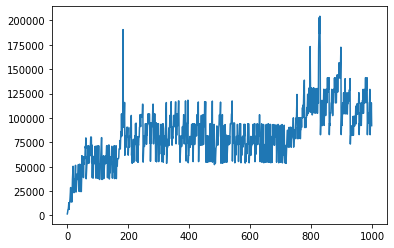

In [64]:
plt.plot(train_loss, label='Training Loss')

plt.show()

In [60]:
losses = loss(net_params,n,label)

opt_init, opt_update,get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(net_params)

params = get_params(opt_state)

up_params, opt_state, loss = update(params, n, label, opt_state)
